# 13. Loading and Preprocessing Data with TensorFlow

#### Setup

In [1]:
import os
from contextlib import ExitStack
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras, data
from keras import (
    callbacks,
    layers,
    losses,
    metrics,
    optimizers,
    Sequential,
)
from tensorflow.train import Example, Feature, Features, BytesList, Int64List, FloatList
import tensorflow_datasets as tfds
import tensorflow_hub as hub


/Users/mmenendezg/Developer/Books/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_PATH = os.path.join('/', 'Users', 'mmenendezg', 'Developer', 'Datasets', 'fashion_mnist')
IMDB_PATH = os.path.join('/', 'Users', 'mmenendezg', 'Developer', 'Datasets', 'imdb_reviews')
SAVE_MODEL_PATH = os.path.join("..", "..", "models", "chapter_13")
SHUFFLE_BUFFER = 60000
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 4096

os.makedirs(DATASET_PATH, exist_ok=True)

In [3]:
def get_log_dir():
    datetime_dir = datetime.now().strftime("%Y%m%d_%H%M")
    log_dir = os.path.join('..', "..", "reports", "logs", datetime_dir)
    return log_dir

#### 9. Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with two features: the serialized image (use tf.io.serialize_tensor() to serialize each image), and the label.⁠ Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.

In [4]:
tf.random.set_seed(1992)

train_set, valid_set, test_set = tfds.load(
    name="fashion_mnist",
    data_dir=DATASET_PATH,
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [5]:
def create_example(image, label):
    """This function creates an example protobufs using the image 
    and label of the `fashion_mnist` dataset

    Args:
        image (tf.Tensor): Array containing the values of the image
        label (int): Value of the class of the image

    Returns:
        binary protobuf: Protobuf containing the image and the label 
    """
    image_data = tf.io.serialize_tensor(image)
    label_data = tf.io.serialize_tensor(label)
    feature = {
        "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
        "label": Feature(int64_list=Int64List(value=[label.numpy()])),
    }
    
    return Example(
        features=Features(
            feature=feature
        )
    )


def save_protobufs(dataset, set_type="train", n_shards=10):
    """This function divides the set into multiple mini sets,
    and saves the images as protobufs in several files

    Args:
        set (tf.data.Dataset): set of tuples (images, target) of the fashion_mnist dataset
    """
    if set_type == "train":
        dataset.shuffle(SHUFFLE_BUFFER)
    files = [
        f"{set_type}.tfrecord-{shard:05d}-of-{n_shards:05d}"
        for shard in range(n_shards)
    ]
    file_paths = [os.path.join(DATASET_PATH, file_path) for file_path in files]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(file)) for file in file_paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return file_paths

In [6]:
train_files = save_protobufs(train_set, "train", n_shards=2)
valid_files = save_protobufs(valid_set, "valid", n_shards=2)
test_files = save_protobufs(test_set, "test", n_shards=2)


In [7]:
def get_record(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]


def mnist_dataset(file_paths, cache=True, shuffle_buffer_size=None):

    dataset = tf.data.TFRecordDataset(file_paths, num_parallel_reads=AUTOTUNE)

    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = (
        dataset.map(get_record, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )
    return dataset


In [8]:
train_set = mnist_dataset(train_files, shuffle_buffer_size=SHUFFLE_BUFFER)
valid_set = mnist_dataset(valid_files)
test_set = mnist_dataset(test_files)

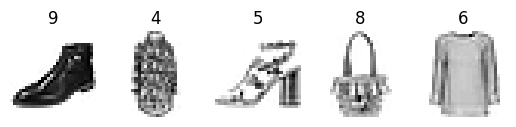

In [9]:
for x, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(x[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [10]:
tf.random.set_seed(1992)
tf.keras.backend.clear_session()

# Normalization of the data
sample_images = train_set.take(250).map(lambda image, label: image)
normalizer = layers.Normalization(input_shape=[28, 28])
normalizer.adapt(sample_images)

# Callbacks
tensorboard_cb = callbacks.TensorBoard(
    log_dir=get_log_dir(), profile_batch=10, histogram_freq=1
)
model_checkpoint_cb = callbacks.ModelCheckpoint(filepath=os.path.join(SAVE_MODEL_PATH, "fashion_mnist"))

model = Sequential(
    [
        normalizer,
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)
model.compile(
    loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="nadam"
)

model.fit(train_set, epochs=50, validation_data=valid_set, callbacks=[tensorboard_cb, model_checkpoint_cb])


Epoch 1/50
     14/Unknown - 1s 45ms/step - loss: 1.3150 - accuracy: 0.5630INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 2s 114ms/step - loss: 1.3150 - accuracy: 0.5630 - val_loss: 0.7107 - val_accuracy: 0.7532
Epoch 2/50
13/14 [==========================>...] - ETA: 0s - loss: 0.6378 - accuracy: 0.7784INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 96ms/step - loss: 0.6368 - accuracy: 0.7785 - val_loss: 0.5670 - val_accuracy: 0.8017
Epoch 3/50
13/14 [==========================>...] - ETA: 0s - loss: 0.5315 - accuracy: 0.8123INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 2s 109ms/step - loss: 0.5317 - accuracy: 0.8122 - val_loss: 0.5347 - val_accuracy: 0.8017
Epoch 4/50
13/14 [==========================>...] - ETA: 0s - loss: 0.4864 - accuracy: 0.8268INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 90ms/step - loss: 0.4856 - accuracy: 0.8273 - val_loss: 0.4615 - val_accuracy: 0.8347
Epoch 5/50
13/14 [==========================>...] - ETA: 0s - loss: 0.4492 - accuracy: 0.8406INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 96ms/step - loss: 0.4490 - accuracy: 0.8406 - val_loss: 0.5146 - val_accuracy: 0.8138
Epoch 6/50
13/14 [==========================>...] - ETA: 0s - loss: 0.4435 - accuracy: 0.8414INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 97ms/step - loss: 0.4436 - accuracy: 0.8414 - val_loss: 0.4439 - val_accuracy: 0.8365
Epoch 7/50
13/14 [==========================>...] - ETA: 0s - loss: 0.4113 - accuracy: 0.8556INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 90ms/step - loss: 0.4113 - accuracy: 0.8556 - val_loss: 0.4266 - val_accuracy: 0.8485
Epoch 8/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3946 - accuracy: 0.8620INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 97ms/step - loss: 0.3946 - accuracy: 0.8619 - val_loss: 0.4099 - val_accuracy: 0.8570
Epoch 9/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3916 - accuracy: 0.8624INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 88ms/step - loss: 0.3911 - accuracy: 0.8625 - val_loss: 0.3878 - val_accuracy: 0.8607
Epoch 10/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3741 - accuracy: 0.8682INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 98ms/step - loss: 0.3744 - accuracy: 0.8681 - val_loss: 0.4507 - val_accuracy: 0.8378
Epoch 11/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3853 - accuracy: 0.8629INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 98ms/step - loss: 0.3848 - accuracy: 0.8632 - val_loss: 0.3775 - val_accuracy: 0.8667
Epoch 12/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3641 - accuracy: 0.8719INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 88ms/step - loss: 0.3637 - accuracy: 0.8722 - val_loss: 0.3802 - val_accuracy: 0.8638
Epoch 13/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3482 - accuracy: 0.8778INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 97ms/step - loss: 0.3482 - accuracy: 0.8777 - val_loss: 0.3773 - val_accuracy: 0.8633
Epoch 14/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3440 - accuracy: 0.8798INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 91ms/step - loss: 0.3441 - accuracy: 0.8799 - val_loss: 0.3828 - val_accuracy: 0.8618
Epoch 15/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3479 - accuracy: 0.8772INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 96ms/step - loss: 0.3480 - accuracy: 0.8770 - val_loss: 0.3663 - val_accuracy: 0.8655
Epoch 16/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3332 - accuracy: 0.8827INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 97ms/step - loss: 0.3328 - accuracy: 0.8829 - val_loss: 0.3662 - val_accuracy: 0.8678
Epoch 17/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3370 - accuracy: 0.8794INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 89ms/step - loss: 0.3365 - accuracy: 0.8796 - val_loss: 0.3608 - val_accuracy: 0.8717
Epoch 18/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3222 - accuracy: 0.8858INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 98ms/step - loss: 0.3223 - accuracy: 0.8859 - val_loss: 0.3698 - val_accuracy: 0.8663
Epoch 19/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3294 - accuracy: 0.8829INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 88ms/step - loss: 0.3295 - accuracy: 0.8831 - val_loss: 0.3560 - val_accuracy: 0.8722
Epoch 20/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3173 - accuracy: 0.8881INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 99ms/step - loss: 0.3172 - accuracy: 0.8882 - val_loss: 0.3594 - val_accuracy: 0.8707
Epoch 21/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3117 - accuracy: 0.8896INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 88ms/step - loss: 0.3114 - accuracy: 0.8897 - val_loss: 0.3524 - val_accuracy: 0.8735
Epoch 22/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3049 - accuracy: 0.8916INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 97ms/step - loss: 0.3046 - accuracy: 0.8916 - val_loss: 0.3464 - val_accuracy: 0.8737
Epoch 23/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3018 - accuracy: 0.8933INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 96ms/step - loss: 0.3018 - accuracy: 0.8933 - val_loss: 0.3325 - val_accuracy: 0.8820
Epoch 24/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3065 - accuracy: 0.8903INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 89ms/step - loss: 0.3060 - accuracy: 0.8905 - val_loss: 0.3371 - val_accuracy: 0.8783
Epoch 25/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2993 - accuracy: 0.8936INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 97ms/step - loss: 0.2997 - accuracy: 0.8935 - val_loss: 0.3656 - val_accuracy: 0.8690
Epoch 26/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2932 - accuracy: 0.8960INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 89ms/step - loss: 0.2931 - accuracy: 0.8962 - val_loss: 0.3361 - val_accuracy: 0.8798
Epoch 27/50
14/14 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.8988INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 98ms/step - loss: 0.2856 - accuracy: 0.8988 - val_loss: 0.3389 - val_accuracy: 0.8798
Epoch 28/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2850 - accuracy: 0.8977INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 96ms/step - loss: 0.2853 - accuracy: 0.8978 - val_loss: 0.3363 - val_accuracy: 0.8807
Epoch 29/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2825 - accuracy: 0.9001INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 88ms/step - loss: 0.2827 - accuracy: 0.9002 - val_loss: 0.3319 - val_accuracy: 0.8795
Epoch 30/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2810 - accuracy: 0.8991INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 97ms/step - loss: 0.2808 - accuracy: 0.8993 - val_loss: 0.3216 - val_accuracy: 0.8830
Epoch 31/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2732 - accuracy: 0.9019INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 90ms/step - loss: 0.2731 - accuracy: 0.9020 - val_loss: 0.3399 - val_accuracy: 0.8770
Epoch 32/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2799 - accuracy: 0.8996INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 97ms/step - loss: 0.2799 - accuracy: 0.8998 - val_loss: 0.3169 - val_accuracy: 0.8885
Epoch 33/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2651 - accuracy: 0.9066INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 97ms/step - loss: 0.2649 - accuracy: 0.9066 - val_loss: 0.3323 - val_accuracy: 0.8788
Epoch 34/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2657 - accuracy: 0.9056INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 88ms/step - loss: 0.2655 - accuracy: 0.9057 - val_loss: 0.3230 - val_accuracy: 0.8833
Epoch 35/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2772 - accuracy: 0.8999INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 100ms/step - loss: 0.2768 - accuracy: 0.8998 - val_loss: 0.3208 - val_accuracy: 0.8845
Epoch 36/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2613 - accuracy: 0.9074INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 92ms/step - loss: 0.2611 - accuracy: 0.9073 - val_loss: 0.3330 - val_accuracy: 0.8788
Epoch 37/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2588 - accuracy: 0.9076INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 103ms/step - loss: 0.2590 - accuracy: 0.9075 - val_loss: 0.3212 - val_accuracy: 0.8840
Epoch 38/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2519 - accuracy: 0.9111INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 104ms/step - loss: 0.2515 - accuracy: 0.9112 - val_loss: 0.3413 - val_accuracy: 0.8762
Epoch 39/50
14/14 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.9021INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 94ms/step - loss: 0.2695 - accuracy: 0.9021 - val_loss: 0.3236 - val_accuracy: 0.8850
Epoch 40/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2515 - accuracy: 0.9104INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 98ms/step - loss: 0.2517 - accuracy: 0.9101 - val_loss: 0.3428 - val_accuracy: 0.8768
Epoch 41/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2513 - accuracy: 0.9105INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 87ms/step - loss: 0.2513 - accuracy: 0.9105 - val_loss: 0.3161 - val_accuracy: 0.8842
Epoch 42/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2420 - accuracy: 0.9146INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 97ms/step - loss: 0.2417 - accuracy: 0.9147 - val_loss: 0.3436 - val_accuracy: 0.8733
Epoch 43/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2512 - accuracy: 0.9109INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 96ms/step - loss: 0.2510 - accuracy: 0.9112 - val_loss: 0.3437 - val_accuracy: 0.8767
Epoch 44/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2430 - accuracy: 0.9134INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 88ms/step - loss: 0.2431 - accuracy: 0.9132 - val_loss: 0.3107 - val_accuracy: 0.8900
Epoch 45/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2369 - accuracy: 0.9161INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 96ms/step - loss: 0.2368 - accuracy: 0.9161 - val_loss: 0.3253 - val_accuracy: 0.8783
Epoch 46/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2357 - accuracy: 0.9160INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 88ms/step - loss: 0.2358 - accuracy: 0.9159 - val_loss: 0.3291 - val_accuracy: 0.8788
Epoch 47/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2363 - accuracy: 0.9157INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 96ms/step - loss: 0.2363 - accuracy: 0.9158 - val_loss: 0.3093 - val_accuracy: 0.8905
Epoch 48/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2298 - accuracy: 0.9190INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 87ms/step - loss: 0.2297 - accuracy: 0.9189 - val_loss: 0.3051 - val_accuracy: 0.8912
Epoch 49/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2297 - accuracy: 0.9187INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 96ms/step - loss: 0.2298 - accuracy: 0.9187 - val_loss: 0.3322 - val_accuracy: 0.8787
Epoch 50/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2316 - accuracy: 0.9177INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/fashion_mnist/assets


14/14 [==============================] - 1s 96ms/step - loss: 0.2319 - accuracy: 0.9176 - val_loss: 0.3211 - val_accuracy: 0.8822


#### 10. In this exercise you will download a dataset, split it, create a tf.data.Dataset to load it and preprocess it efficiently, then build and train a binary classification model containing an Embedding layer:

#### - Download the Large Movie Review Dataset, which contains 50,000 movie reviews from the Internet Movie Database (IMDb). The data is organized in two directories, train and test, each containing a pos subdirectory with 12,500 positive reviews and a neg subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words versions), but we will ignore them in this exercise.

#### - Split the test set into a validation set (15,000) and a test set (10,000).

In [11]:
train_set, valid_set, test_set = tfds.load(
    name="imdb_reviews",
    data_dir=IMDB_PATH,
    split=["train", "test[:15000]", "test[15000:]"],
    as_supervised=True,
)

In [12]:
for text in train_set.take(1):
    print(text[0])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)


#### - Use tf.data to create an efficient dataset for each set.

In [13]:
train_set = train_set.cache()
valid_set = valid_set.cache()
test_set = test_set.cache()

train_set = train_set.shuffle(SHUFFLE_BUFFER).batch(32).prefetch(AUTOTUNE)
valid_set = valid_set.batch(32).prefetch(AUTOTUNE)
test_set = test_set.batch(32).prefetch(AUTOTUNE)

#### - Create a binary classification model, using a TextVectorization layer to preprocess each review.

In [14]:
def train_model(train_set, valid_set, test_set, epochs=100):
    """This function trains a model with the data feeded.
    The function saves the model in a separate folder.

    Args:
        train_set (tf.data.Dataset): Dataset containing the training records
        valid_set (tf.data.Dataset): Dataset containing the values for validation
        test_set (tf.data.Dataset): Dataset containing the values to evaluate the model
        epochs (int, optional): Max number of epochs the model will be trained. Defaults to 100.

    Returns:
        model(tf.keras.Model): Model trained
    """
    keras.backend.clear_session()
    tf.random.set_seed(1992)

    max_tokens = 5000
    sample_text = train_set.map(lambda review, label: review)
    vectorizer = layers.TextVectorization(max_tokens=max_tokens, output_mode="tf_idf")
    vectorizer.adapt(sample_text)

    model = Sequential(
        layers=[
            vectorizer,
            layers.Dense(
                100,
                kernel_initializer="he_normal",
                activation="elu",
            ),
            layers.Dense(
                100,
                kernel_initializer="he_normal",
                activation="elu",
            ),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="imdb_model",
    )

    # Compile the model
    loss = losses.binary_crossentropy
    optimizer = optimizers.Nadam()
    metric = metrics.accuracy

    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

    # Callbacks
    tensorboard_cb = callbacks.TensorBoard(log_dir=get_log_dir(), profile_batch=5)
    early_stopping_cb = callbacks.EarlyStopping(patience=5)
    model_checkpoint_cb = callbacks.ModelCheckpoint(
        filepath=os.path.join(SAVE_MODEL_PATH, "imdb_model"), save_best_only=True
    )
    callbacks_list = [tensorboard_cb, early_stopping_cb, model_checkpoint_cb]

    model.fit(
        train_set,
        validation_data=valid_set,
        epochs=epochs,
        callbacks=callbacks_list,
        verbose=0,
    )

    evaluation = model.evaluate(test_set, verbose=0)

    print(f"The model {model.name} has successfully been trained.")
    print(
        f"The training metrics are: \n\tAccuracy: {(evaluation[0]) * 100:.2f}\n\tLoss: {evaluation[1]:.2f}"
    )
    return model


In [15]:
imdb_model = train_model(train_set, valid_set, test_set)

INFO:tensorflow:Assets written to: ../../models/chapter_13/imdb_model/assets


INFO:tensorflow:Assets written to: ../../models/chapter_13/imdb_model/assets


The model imdb_model has successfully been trained.
The training metrics are: 
	Accuracy: 87.62
	Loss: 0.15


#### - Add an Embedding layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model.

#### - Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible.

#### - Use TFDS to load the same dataset more easily: tfds.load("imdb_reviews").